## Main packages

In [50]:
import pandas as pd
import numpy as np

## Data

In [511]:
loads = pd.read_csv('../data/clean/loads/HighLoads.csv')
loads.head()

,year,month,day,hour,01-hermosillo,02-cananea,03-obregon,04-los_mochis,05-culiacan,06-mazatlan,...,44-chetumal,45-cozumel,46-tijuana,47-ensenada,48-mexicali,49-san_luis_rio_colorado,50-villa_constitucion,51-la_paz,52-los_cabos,53-mulege
0,2016,1,1,1,504.498675,129.188054,260.404221,209.213337,248.641430,126.300735,...,51.556994,24.608736,309.851182,92.032840,533.469310,111.953328,20.776124,85.358718,96.985377,13.0
1,2016,1,1,2,488.338710,125.049937,252.063023,202.511873,240.677015,122.255104,...,50.192867,23.957623,289.500525,85.988232,498.431681,104.600366,19.639420,80.688568,91.679109,12.0
2,2016,1,1,3,477.000496,122.146537,246.210642,197.809966,235.088993,119.416594,...,48.815369,23.300128,274.399318,81.502831,472.432004,99.144101,18.876530,77.554236,88.117851,11.0
3,2016,1,1,4,459.073513,117.555936,236.957373,190.375727,226.253706,114.928592,...,47.514468,22.679193,263.625959,78.302899,453.883564,95.251544,18.005244,73.974556,84.050585,11.0
4,2016,1,1,5,447.413277,114.570074,230.938775,185.540279,220.506976,112.009463,...,46.195586,22.049675,252.258161,74.926404,434.311679,91.144208,17.331962,71.208377,80.907627,11.0


## Data preparation

In [517]:
# Calculate the sum of all loads
loads['total'] = loads.sum(axis=1)

# Create datetimeindex for easy query
loads.index = pd.to_datetime(loads[['year', 'month', 'day', 'hour']])


# Transform 24 hours to 0 to be in accordance with CENACE
loads.loc[loads['hour'] == 24, 'hour'] = 0

# Move changed hours to next day
loads.loc[loads['hour'] == 0].index += pd.DateOffset(day=1)

# Get the last year of the load timeseries
last_year = loads.index.year[-1]

loads.loc[loads['year'] > last_year].index = loads.loc[loads['year'] > last_year].index.year - 1
loads = loads.sort_index()

/usr/local/lib/python3.6/site-packages/pandas/core/indexes/datetimes.py:831: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


## Representative days

In [ ]:
def get_representative_day(data, dates, number=4):
    """ Construc a representative day based on a single timestamp
    
    Args:
    data
    dates
    number
    Todo: Write readme
    """
    years = []
    if isinstance(dates, pd.Series):
        for day in dates:
            i_date = day - pd.DateOffset(hours=12)
            f_date = day + pd.DateOffset(hours=12)
            mask = (data.index >= i_date) & (data.index <= f_date)
            # reset_index to preserve timepoint reference
            years.append(data.loc[mask].iloc[::number].reset_index())
    else:
        i_date = dates - pd.DateOffset(hours=12)
        f_date = dates + pd.DateOffset(hours=12)
        mask = (data.index >= i_date) & (data.index <= f_date)
        years.append(data.loc[mask].iloc[::number].reset_index())
    output_data = pd.concat(years)
    output_data.rename(columns={'index':'date'}, inplace=True)
    return output_data

## Timepoints creation

For the timepoints creation we are going to retrieve the maximum of each day and the median of the average of every month.

### Peak days

In [408]:
timepoints = loads.groupby([pd.TimeGrouper('A'), 
                                 pd.TimeGrouper('M')])['total'].idxmax()
timepoints.head()

2016-12-31  2016-01-31   2016-01-28 20:00:00
            2016-02-29   2016-02-25 20:00:00
            2016-03-31   2016-03-31 21:00:00
            2016-04-30   2016-04-29 17:00:00
            2016-05-31   2016-05-27 22:00:00
Name: total, dtype: datetime64[ns]

In [614]:
def get_representative_day(data, number=4, freq='MS'):
    """ Construc a representative day based on a single timestamp
    # Month start is to avoid getting more timepoints in a even division
    Args:
    data
    dates
    number
    Todo: Write readme
    """
    years = []
    if number & 1:
        raise ValueError('Odd number of timepoints. Use even number')
    for index, group in data.groupby([pd.TimeGrouper('A'), pd.TimeGrouper(freq=freq)]):
        peak_timestamp = group.idxmax()
        mask = peak_timestamp.strftime('%Y-%m-%d') 
        years.append(group.loc[mask].iloc[::int((24/4))].reset_index())    
    output_data = pd.concat(years)
    output_data.rename(columns={'index':'date', 'total':'peak_day'}, inplace=True)

    return output_data
peak_dates = get_representative_day(loads['total']['2016'], number=4);
peak_dates;

### Median days

In [617]:
def get_median_day(data, number=4, freq='MS'):
    years = []
    for index, group in loads[['total']].groupby([pd.TimeGrouper('A'), pd.TimeGrouper('MS')]):
        grouper = group.groupby(pd.TimeGrouper('D')).mean()
        if len(grouper) & 1:
            # Odd number of days
            index_median = grouper.loc[grouper['total']==grouper['total'].median()].index[0]
        else:
            # Even number of days
            index_median = (np.abs(grouper['total']-grouper['total'].median())).argmin()
        years.append(group.loc[index_median.strftime('%Y-%m-%d')].iloc[::int((24/number))].reset_index())
    output_data = pd.concat(years)
    output_data.rename(columns={'index':'date', 'total':'peak_day'}, inplace=True)

    return output_data
mean_days = get_median_day(loads)
mean_days.head()

,date,peak_day
0,2016-01-09 00:00:00,93675.639265
1,2016-01-09 06:00:00,82182.565493
2,2016-01-09 12:00:00,100287.294283
3,2016-01-09 18:00:00,99949.999419
0,2016-02-05 00:00:00,97893.653637


In [597]:
import sys
median_days = pd.DataFrame()
for index, group in loads[['total']].groupby([pd.TimeGrouper('A'), pd.TimeGrouper('MS')]):
    grouper = group.groupby(pd.TimeGrouper('D')).mean()
    if len(grouper) & 1:
        # Odd number of days
        index_median = grouper.loc[grouper['total']==grouper['total'].median()].index[0]
        median_days.loc[index[1], 'median_day'] = index_median
    else:
        # Even number of days
        index_median = (np.abs(grouper['total']-grouper['total'].median())).argmin()
        median_days.loc[index[1], 'median_day'] = index_median
    group.loc[index_median.strftime('%Y-%m-%d')].iloc[::int((24/number))].reset_index()
mean_days;

,total
2030-12-06 00:00:00,163190.240738
2030-12-06 01:00:00,161448.654410
2030-12-06 02:00:00,152765.846365
2030-12-06 03:00:00,148325.923604
2030-12-06 04:00:00,143756.074415
2030-12-06 05:00:00,143788.604240
2030-12-06 06:00:00,145629.858696
2030-12-06 07:00:00,149627.112542
2030-12-06 08:00:00,152831.963168
2030-12-06 09:00:00,161470.619588


## Debug

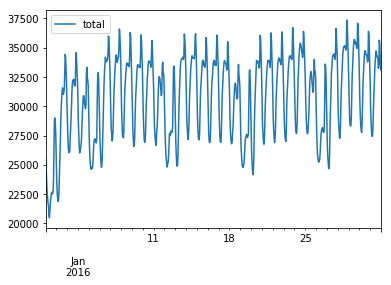

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
loads['2016-01'].plot(y='total', ax=ax)

In [83]:
loads['2016-01']['total'].min()

20475.506218809998